# Tutorial for POPPY: Physical Optics Propagation in PYthon

This document is not intended as comprehensive documentation for the ``poppy`` package. Please see [the documentation](http://pythonhosted.org/poppy/) for full details in the API, and the SPIE papers by Perrin et al. ([2012](http://adsabs.harvard.edu/abs/2012SPIE.8442E..3DP), 2014) for further background information and discussion of algorithms.  However this notebook should be enough to get you started. 

Poppy implements an object-oriented system for modeling physical optics propagation with diffraction, particularly for telescopic and coronagraphic imaging. This tutorial covers the Fraunhofer (far-field) diffraction mode of ``poppy``, which new users should start with.  Fresnel modeling is covered in a separate tutorial.

## Getting Started

You should be able to install poppy directly from PyPI in the usual manner: 

<pre>
  pip install poppy --upgrade
  </pre>

In [1]:
import poppy
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
poppy.__version__

Populating the interactive namespace from numpy and matplotlib


'0.8.0'

For all of the following examples, you will have more informative text output when running the code if you first enable Python’s logging mechanism to display log messages to screen. This can sometimes be more verbose than is desired, so feel free to turn this on or off as desired. 

In [2]:
import logging
logging.getLogger('poppy').setLevel(logging.WARN)  
#Can be logging.CRITICAL, logging.WARN, logging.INFO, logging.DEBUG for increasingly verbose output

## Working with OpticalElements

OpticalElements can be instantiated from FITS files, or created by one of a large number of analytic function definitions implemented as AnalyticOpticalElement subclasses. Typically these classes take some number of arguments to set their properties. Once instantiated, any analytic function can be displayed on screen, sampled onto a numerical grid, and/or saved to disk.:

(<matplotlib.axes._subplots.AxesSubplot at 0x1ff222fa278>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ff22557400>)

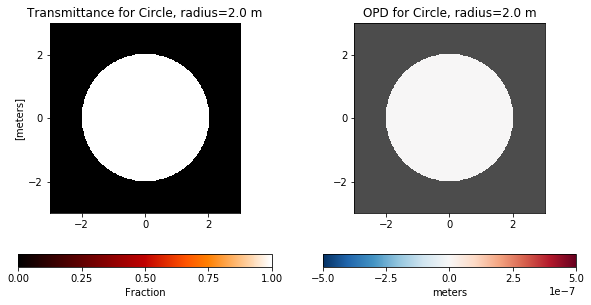

In [3]:
ap = poppy.CircularAperture(radius=2)
values = ap.sample(npix=512)    # evaluate on 512 x 512 grid

plt.figure(figsize=(10,5))
ap.display(what='both')         # display phase and amplitude transmission;


Optics come in two basic types: **pupil** and **image** plane optics. The circular aperture above is a pupil plane optic, as are SquareAperture, HexagonalAperture, and many other classes. Pupil plane optics are dimensioned in meters.  

Image plane optics include various types of coronagraph and spectrograph image plane masks.   In the basic Fraunhofer propagation mode of ``poppy``, image plane optics are dimensioned in arcseconds for convenience.  Their physical scale is not modeled in detail, but is scaled proportionate to the implied angular scale of any images formed from the pupil plane optics. (The Fresnel mode works somewhat differently, but that's a topic for later.)

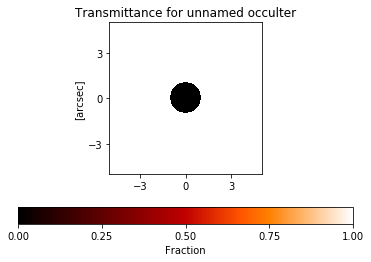

In [4]:
spot = poppy.CircularOcculter()
spot.display();

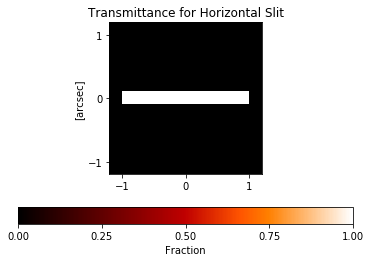

In [5]:
my_slit = poppy.optics.RectangularFieldStop(width=2, height=0.2, name='Horizontal Slit')
my_slit.display();

Optics can have phase as well as amplitude.  Depending on the particular class, phases may be specified using physical units for optical path difference in nanometers, or specified in terms of some number of waves for a given wavelength.

Note that wavelengths are always in meters. 

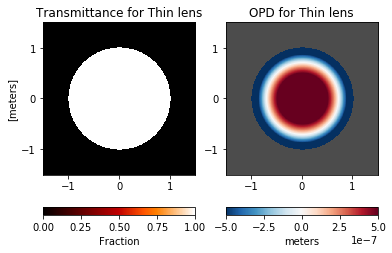

In [6]:
poppy.ThinLens(nwaves=2, reference_wavelength=1e-6, radius=1).display(what='both');

In addition to image and pupil optics, there are **Detector** objects which define how to sample a PSF into an array (pixel scale, field of view), and there are **Rotation** objects, which represent a coordinate system rotation around the optical axis. 

## Working with Optical Systems and Creating PSFs

One or more OpticalElements can be arranged into an OpticalSystem, which functions in many ways like a python List, but distinguishes between pupil and image planes. OpticalSystems should start with at least one pupil plane optic, and must end with a Detector element that defines the desired sampling. 

A basic circular pupil is simple to set up and to compute the PSF for, as it should be. 

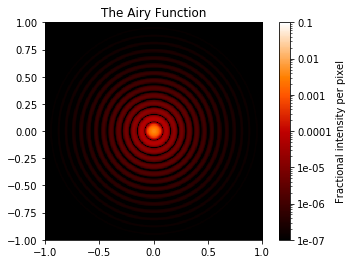

In [7]:
osys = poppy.OpticalSystem()
osys.add_pupil( poppy.CircularAperture(radius=3))    # pupil radius in meters
osys.add_detector(pixelscale=0.010, fov_arcsec=2.0)  # image plane coordinates in arcseconds

psf = osys.calc_psf(2e-6)                            # wavelength in microns
poppy.display_psf(psf, title='The Airy Function')

Note that the returned PSF is in fact a FITS HDUlist object (from ``astropy.io.fits``), suitable for saving to disk for use with standard astronomical tools. 

The FITS header contains information about the calculation that produced the PSF. 

In [8]:
psf

In [9]:
psf[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  400                                                  
NAXIS2  =                  400                                                  
EXTEND  =                    T                                                  
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN =                2E-06 / Weighted mean wavelength in meters             
DIFFLMT =  0.06875493541569878 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    2 / Oversampling factor for FFTs in computation    
DET_SAMP=                    2 / Oversampling factor for MFT to detector plane  
PIXELSCL=                0.005 / Scale in arcsec/pix (after oversampling)       
FOV     =                  2

By combining multiple analytic optics together it is possible to create quite complex pupils:



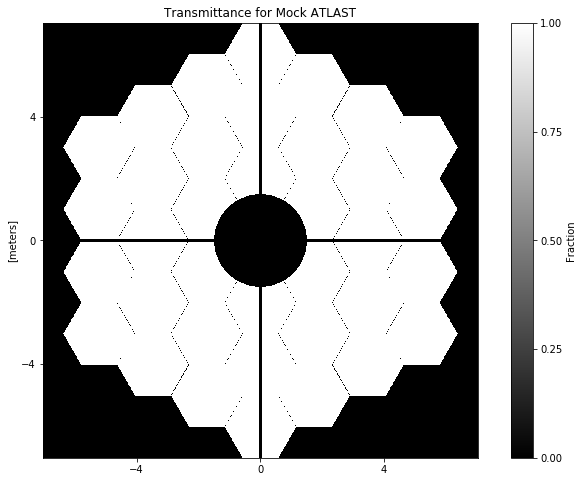

In [10]:
ap = poppy.MultiHexagonAperture(rings=3, flattoflat=2)           # 3 rings of 2 m segments yields 14.1 m circumscribed diameter
sec = poppy.SecondaryObscuration(secondary_radius=1.5, n_supports=4, support_width=0.1)   # secondary with spiders
atlast = poppy.CompoundAnalyticOptic( opticslist=[ap, sec], name='Mock ATLAST')           # combine into one optic

plt.figure(figsize=(12,8))
atlast.display(npix=1024, colorbar_orientation='vertical')


And here’s the PSF:

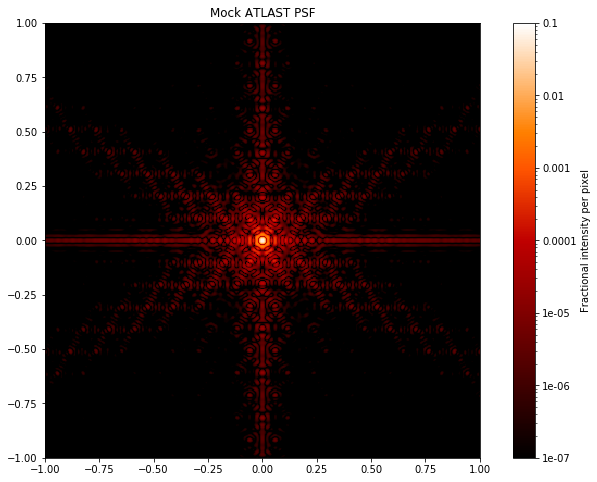

In [11]:
osys = poppy.OpticalSystem()
osys.add_pupil(atlast)
osys.add_detector(pixelscale=0.010, fov_arcsec=2.0)
psf = osys.calc_psf(1e-6)

plt.figure(figsize=(12,8))
poppy.display_psf(psf, title="Mock ATLAST PSF")

## Multi-Plane calculations

Many optical systems involve propagation between intermediate image and pupil planes. For instance, spectrographs will have an entrance slit at an intermediate image plane, while coronagraphs can have a dizzying variety of image and/or pupil plane stops, occulters, and phase masks to shape the diffraction pattern. 

As an example of a more complicated calculation, here’s a simple classical Lyot coronagraph. In this example we intentionally create some blank planes in order to show the intensity both before and after the coronagraph stops.

The total intensity in the output PSF is only 0.016 of the input.


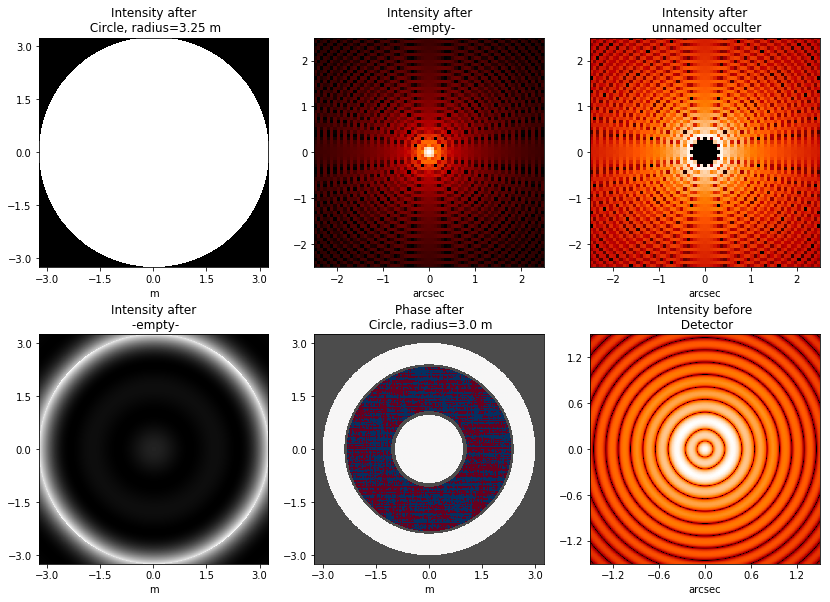

In [12]:
oversample=2
pixelscale = 0.010  #arcsec/pixel
wavelength = 4.6e-6

osys = poppy.OpticalSystem("test", oversample=oversample)
osys.add_pupil(poppy.CircularAperture(radius=3.25))
osys.add_image()
osys.add_image(poppy.CircularOcculter(radius=0.3))
osys.add_pupil()
lyot = poppy.CircularAperture(radius=3)
lyot._wavefront_display_hint='intensity' # advanced tweak: ensure intensity rather than phase gets displayed
osys.add_pupil(lyot)
osys.add_detector(pixelscale=pixelscale, fov_arcsec=3.0)

plt.figure(figsize=(14,10))
corpsf = osys.calc_psf(wavelength=wavelength, display_intermediates=True)

print("The total intensity in the output PSF is only {0:.3f} of the input.".format(corpsf[0].data.sum()))

The OpticalSystem class has a few attributes that can be used to adjust the properties of the calculation, for instance the location of the source can be offset from the center of the field.  

Let's repeat the same calculation, but with the source moved off-center. 

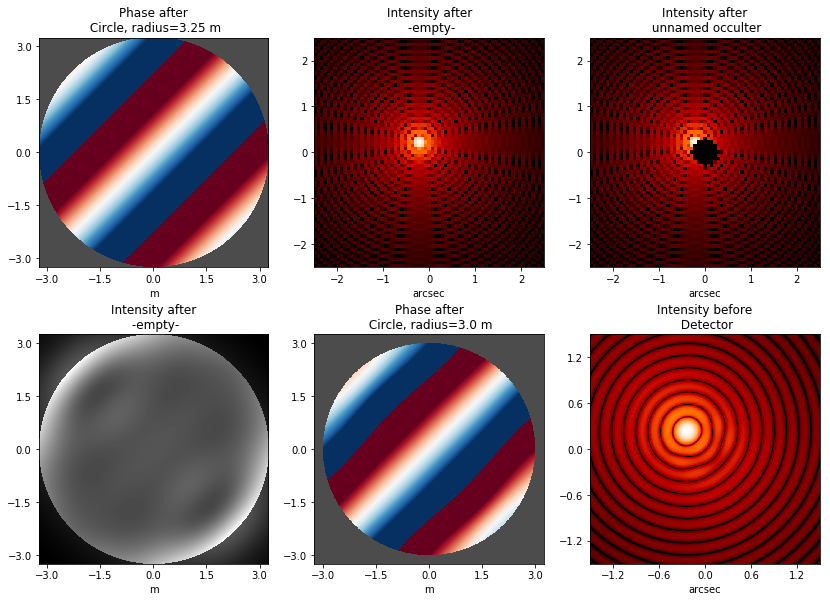

In [13]:
osys.source_offset_theta = 45.
osys.source_offset_r =  0.3  # arcsec

plt.figure(figsize=(14,10))
corpsf2 = osys.calc_psf(wavelength=wavelength, display_intermediates=True)

## Working with PSFs

``poppy`` includes several utility functions for evaluating and displaying PSFs.  These all expect PSFs in the HDUlist format returned from ``poppy`` calculations, and use the FITS header metadata when rendering the display. 

We've already seen the ``display_psf`` function. 

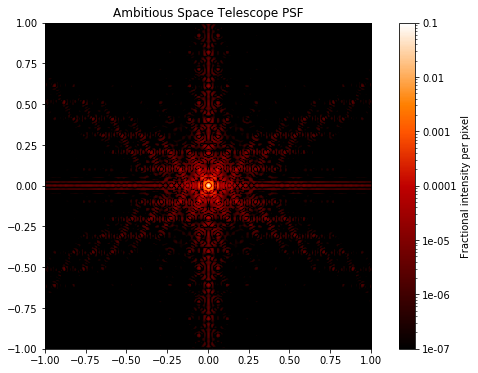

In [14]:
plt.figure(figsize=(10,6))
poppy.display_psf(psf, title='Ambitious Space Telescope PSF')

There is also a function for showing the difference between two PSFs. 

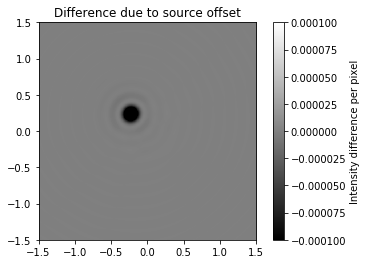

In [15]:
poppy.display_psf_difference(corpsf,corpsf2, title='Difference due to source offset')

And one for showing radial profiles:

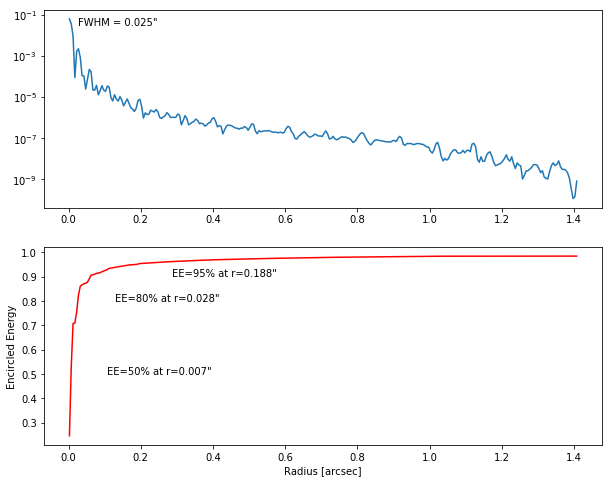

In [16]:
plt.figure(figsize=(10,8))
poppy.display_profiles(psf)

These profiles can be evaluated using 2 different functions:
1. measure_ee() creates a function which allows you to input a radius and will output the EE value at that radius.
2. measure_radius_at_ee() creates a function which allows you to input an EE value and will output the radius where that EE value is found

In [17]:
ee = poppy.measure_ee(psf)
rad = poppy.measure_radius_at_ee(psf)

print("The EE is {0:.1f}% at radius=0.5 arcsec".format(float(ee(0.5))*100))
print("The radius is {0:.3f} arcsec at EE=50%".format(float(rad(0.5))))

print("These functions undo each other: the input = {0:.3f} yields ee(rad(input)) = {0:.3f}".format(
    0.1, float(ee(rad(0.1)))))

The EE is 97.3% at radius=0.5 arcsec
The radius is 0.033 arcsec at EE=50%
These functions undo each other: the input = 0.100 yields ee(rad(input)) = 0.100


One can also make a variety of measurements, for instance the center. 

In this case, we see that for an even-sized array, the PSF is by default centered exactly in the middle between 4 pixels symmetrically.  (Remember that pixel centers have integer coordinates, so values ending in .5 are centered between adjacent pixels.)

In [20]:
print("The PSF array shape is ", psf[0].data.shape)
print("The centroid is located at ({0:.3f}, {1:.3f})".format(*poppy.measure_centroid(psf)))

The PSF array shape is  (400, 400)
The centroid is located at (199.500, 199.500)


'e:\\Users\\tedco\\Anaconda3\\lib\\site-packages\\poppy\\__init__.py'

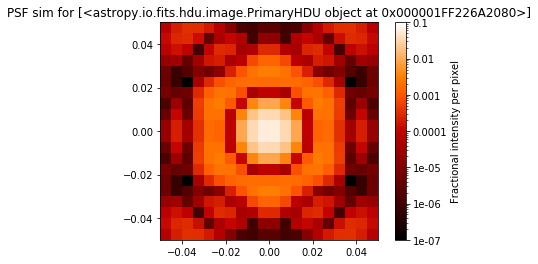

In [21]:
poppy.display_psf(psf, imagecrop=0.1)
poppy.__file__

In [22]:
print("The FWHM is {0:.3f} arcsec at {1} microns ".format(poppy.measure_fwhm(psf), psf[0].header['WAVELEN']*1e6))

The FWHM is 0.015 arcsec at 1.0 microns 


## Next Steps

The package documentation lists the other available OpticalElement classes, and has some examples of more complex coronagraphic calculations. 

You may find that you need an OpticalElement which is not represented among the various predefined classes. There are two ways to proceed in this case. 

1. You can create a representation of that optic using some outside tool, and save it as a FITS file to load in using the FITSOpticalElement class. This allows representing arbitrarily complex apertures, so long as it is sufficient to do so on a fixed numerical grid.
2. You may define your own OpticalElement classes that define complex analytic functions that will be evaluated on the fly. The existing elements provide a good starting point for this, and see also the several custom OpticalElements defined inside the WebbPSF package. 

We encourage users to contribute their own models and simulations back into the poppy Examples page. Similarly if you create any generally useful OpticalElement classes, pull requests are very much welcomed. 

